# QTS Final Project: Regression Prediction on Petro-Currencies


Aman Krishna, Student ID: 12371175;<br> Christian Pavilanis, Student ID: 12365328;<br> Jingwen Li, Student ID: 12369843;<br> Yazmin Ramirez Delgado, Student ID: 12371019 <br>

# 1. Intro

It all started with a simple but powerful idea: could we predict the trend of FX currency with available information and build a model to trade on our predictions? With this idea, we embarked on a thrilling journey of exploration, trying out various regression techniques and shortening our time frame from long-term to intra-day.

As we experimented with cross-sectional regression, gradient boosting, and candlestick regression with momentum, we experienced many ups and downs. But through perseverance and hard work, we gradually saw an improvement in our prediction accuracy.

And that's when things got really exciting. Armed with our newfound trading strategy, we were able to trade on our predictions and generate a profit. It was an incredible feeling to see our initial idea turn into a successful trading strategy.

In [21]:
import numpy as np
import pandas as pd
import quandl
import nasdaqdatalink as ndl
import pyreadr
import functools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
from prettytable import PrettyTable
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
ndl.ApiConfig.api_key = key

# 2. Collect and clean data

## 2.1 Collect FX data from Quandl

In [2]:
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2=ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [3]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities,sdate,edate):
    qdata = quandl.get(list(my_securities), returns='pandas',authtoken=key,start_date=sdate, end_date=edate)
    return qdata

In [4]:
def fetch_fx(cur_code, sdate, edate):
    currencies = ['AUD', 'JPY', 'NZD', 'CAD', 'CHF', 'EUR', 'PLN', 'GBP', 'MXN', 'TRY']
    
    if cur_code not in currencies:
        raise ValueError(f'code not in our list, available currencies are {currencies}')

    fx = fetch_quandl(('CUR/{}'.format(cur_code),), sdate, edate)

    return fx

def fetch_commodities(para_code, sdate, edate):
    commodities = ['FRED/DCOILWTICO','FRED/DCOILBRENTEU','FRED/DHHNGSP', 'LBMA/GOLD', 'LBMA/SILVER']

    if para_code not in commodities:
        raise ValueError(f'code not in our list, available commodities are {commodities}')

    data = fetch_quandl((para_code,), sdate, edate)

    return data

>The above code defines two functions: fetch_fx and fetch_commodities which fetch financial data from Quandl API based on the specified currency or commodity codes, start date, and end date.
>
>The fetch_fx function takes three parameters: cur_code, sdate, and edate. cur_code is a string representing the currency code for which the user wants to fetch financial data. The sdate and edate parameters represent the start and end dates respectively for the financial data. The function checks if cur_code is in the list of available currencies currencies and if not, raises a ValueError with a message indicating the available currencies. If cur_code is valid, the function uses the fetch_quandl function to fetch financial data for the specified currency and returns the data.
>
>The fetch_commodities function is similar to fetch_fx, but instead of currency codes, it takes para_code as the first parameter which represents the commodity code. The function checks if para_code is in the list of available commodities commodities and raises a ValueError if not. If para_code is valid, the function uses the fetch_quandl function to fetch financial data for the specified commodity and returns the data.
>
>Both functions use the fetch_quandl function to make a request to the Quandl API and return the data for the specified financial code, start date, and end date.

In [5]:
currencies = ['AUD', 'JPY', 'NZD', 'CAD', 'CHF', 'EUR', 'PLN', 'GBP', 'MXN', 'TRY']
dfs = []
for currency in currencies:
    fx = fetch_fx(currency, '2008-10-31', '2023-03-01')
    df = pd.DataFrame({f'{currency}': fx[f'CUR/{currency} - RATE']})
    dfs.append(df)

cur = pd.concat(dfs, axis=1)
cur.head()

,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,TRY
DATE,,,,,,,,,,
2008-10-31,1.508963,98.320364,1.713778,1.216053,1.156579,0.785374,2.819315,0.618254,12.703598,1.554999
2008-11-01,NaN,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,1.549599
2008-11-02,NaN,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,1.549599
2008-11-03,1.475190,98.819425,1.688489,1.190056,1.166273,0.788065,2.775932,0.627786,12.787491,1.539369
2008-11-04,1.437270,99.755235,1.647282,1.159276,1.164538,0.772049,2.750858,0.626918,12.543740,1.504792


## 2.2 Merge with data of commodities and other parameters collected from Bloomberg

In [8]:
parameters = pd.read_excel("parameters.xlsx")
parameters = parameters.set_index('Date')

In [9]:
df = cur.merge(parameters, left_index=True, right_index=True)
# df.to_csv('ml_vf_data.csv')

In [10]:
# Read the ml_data.csv file 
ml_data = pd.read_csv('ml_vf_data.csv')
ml_data = ml_data.set_index('DATE')
# Change the column names to upper case
ml_data.columns = map(str.upper, ml_data.columns)
# Forwards fill the missing values
ml_data = ml_data.fillna(method='ffill')
# Drop NA values
ml_data = ml_data.dropna()
ml_data.head()

,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,TRY,...,JPY_IR,MXN_IR,CANADA_CRUDE,WTI_CRUDE,BRENT_CRUDE,NATURAL_GAS,GOLD,SILVER,COPPER,MAYA_CRUDE
DATE,,,,,,,,,,,,,,,,,,,,,
2008-10-31,1.508963,98.320364,1.713778,1.216053,1.156579,0.785374,2.819315,0.618254,12.703598,1.554999,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2008-11-01,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,1.549599,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2008-11-02,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,1.549599,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2008-11-03,1.475190,98.819425,1.688489,1.190056,1.166273,0.788065,2.775932,0.627786,12.787491,1.539369,...,0.3,8.25,42.91,63.91,60.32,6.838,723.55,9.84,255.6875,46.93
2008-11-04,1.437270,99.755235,1.647282,1.159276,1.164538,0.772049,2.750858,0.626918,12.543740,1.504792,...,0.3,8.25,49.78,70.53,62.78,7.219,763.27,10.22,268.9375,49.86


First, let's do some analysis on the data. We'll start by looking at the distribution of the data.

In [14]:
# Analysis of the data
# describe the data
ml_data.describe().iloc[:,0:10]

,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,TRY
count,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000
mean,1.251158,104.043287,1.412668,1.196223,0.966739,0.827944,3.562012,0.701979,16.532461,4.631691
std,0.182025,15.023752,0.153322,0.136556,0.063955,0.081032,0.471359,0.074918,3.392534,4.314187
min,0.906698,75.751979,1.133563,0.942869,0.728006,0.661779,2.645209,0.582661,11.507680,1.393124
25%,1.082998,93.096652,1.291345,1.046784,0.923507,0.755463,3.152709,0.633891,13.064535,1.795525
50%,1.302762,106.780596,1.411813,1.253168,0.963580,0.840253,3.665520,0.692555,17.246070,2.912077
75%,1.393089,112.470529,1.503986,1.313348,0.994090,0.893355,3.871085,0.766638,19.548920,5.826735
max,1.782022,150.386818,2.026932,1.460735,1.221934,1.047039,5.024032,0.949311,25.628142,18.885700


>The above distribution of Forex Currencies shows that the some currencies like CHF and AUD trade in a very small band, while others like TRY and MXN trade in a much wider band. This is an important consideration when we are looking to build a trading strategy based on the data.
>
>Since the distribution covers the entire time period from 2008 to 2023, we will see more patterns in the data when we look at the data for a shorter and more focussed time periods.

In [17]:
ml_data.describe().iloc[:,14:]

,CANADA_CRUDE,WTI_CRUDE,BRENT_CRUDE,NATURAL_GAS,GOLD,SILVER,COPPER,MAYA_CRUDE
count,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000,5233.000000
mean,53.867621,70.405221,76.155219,3.565215,1413.925433,20.865346,432.364551,67.018722
std,20.157690,22.264193,26.020002,1.296379,280.416144,6.533820,97.932757,23.676425
min,3.810000,-37.630000,9.120000,1.482000,712.250000,8.958800,175.593750,-7.560000
25%,36.870000,51.470000,54.800000,2.701000,1223.140000,16.331800,366.109375,47.150000
50%,52.670000,69.290000,72.260000,3.284000,1324.850000,18.427400,426.437500,64.160000
75%,70.730000,90.660000,103.360000,4.169000,1670.530000,24.297500,493.312500,89.730000
max,110.960000,123.700000,133.180000,9.680000,2063.540000,48.443800,706.218750,119.340000


>The different Crude Oil commodities have a similar distribution, with the exception of Brent Crude which has a wider range of prices. This is likely due to the fact that Brent Crude is a global benchmark for oil prices, while the other commodities are regional benchmarks.
>
>We will analyze this further with some timeseries and correlation charts.

# 3. Cross Sectional Regression Analysis

    Our project was inspired by an article on oil-backed foreign exchange. The article suggested that the currency exchange of oil-producing countries would also bounce back with the bullish outlook for crude oil. However, market analysts had only tested the correlation between petrocurrency and oil price, instead of exploring the causality. Correlation does not necessarily imply causation, and the true underlying relationship between oil prices and petro-currencies remained unclear.

    We sought to explore this relationship through empirical analysis and computer simulation on various petrocurrencies, using regression techniques to examine the potential drivers of currency price movements. We collected commodity data, as well as information on other factors such as interest rates and precious metals, with the goal of building a prediction model for petrocurrency prices.

    Our quantitative trading strategy aims to find particular rhythms and signals generated by macroeconomic phenomena to trade in the FX market. The FX market is more structured and generally carries fewer arbitrage opportunities than the equity or other derived markets, so we looked to enhance our trading strategy through multiple signals from the commodity, cross-currency, and interest rate market data.

    We implemented several strategies and backtested them to determine the most robust one. 


    Here we are using GBP as an example to examine the potential drivers of currency price movements. We will use collected commodity data, as well as information on other factors such as interest rates and precious metals, to run cross sectional regression on it with the goal of building a prediction model for petrocurrency prices.


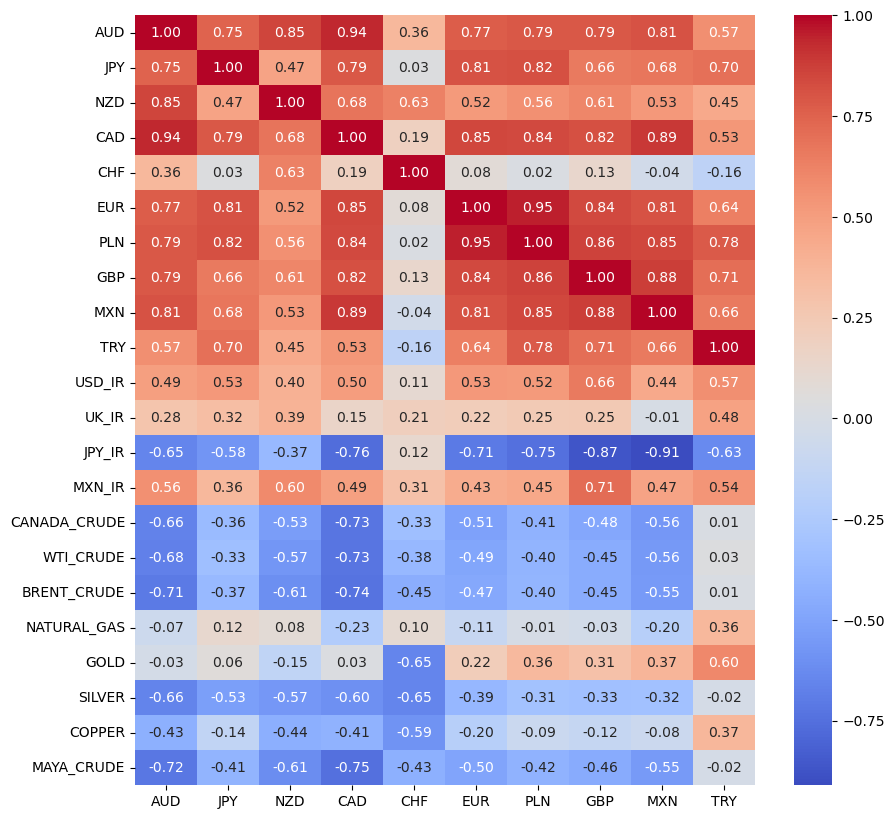

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(ml_data.corr().iloc[:,0:10],annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

>The correlation matrix provides information about the strength and direction of the linear relationship between pairs of variables. A correlation value of 1 indicates a perfect positive linear relationship, while a correlation value of -1 indicates a perfect negative linear relationship. A correlation value of 0 indicates no linear relationship between the variables.
>
>Looking at the provided correlation matrix, we can see that AUD and NZD have a strong positive correlation of 0.85, which indicates that these two currencies tend to move together. AUD and CAD also have a strong positive correlation of 0.94, which suggests that these two currencies are also likely to move together.
>
>On the other hand, JPY and CHF have a very weak positive correlation of 0.03, which indicates that these two currencies do not move together. Similarly, the correlation between JPY and MXN is weakly positive at 0.68, suggesting that these two currencies do not move together.
>
>In addition to the currency pairs, the matrix also provides correlations between currencies and other variables such as interest rates and commodities. For example, the correlation between USD_IR and GBP is 0.66, indicating a positive relationship between the USD interest rate and the GBP exchange rate. The negative correlations between crude oil and the exchange rates of various currencies suggest that changes in crude oil prices are inversely related to changes in exchange rates.

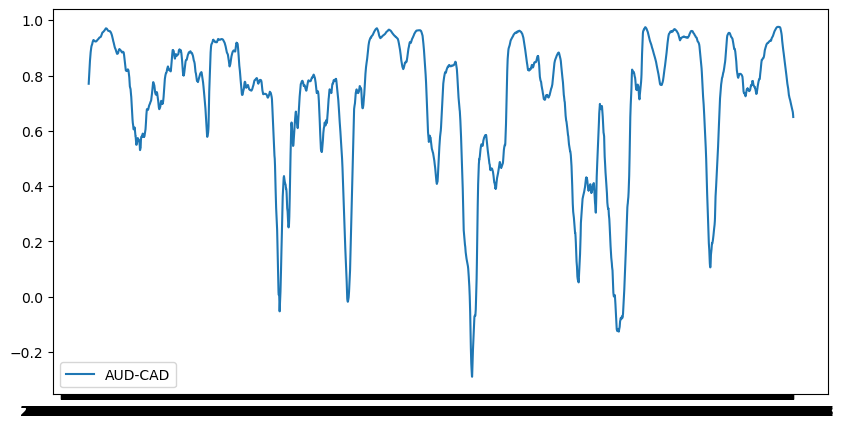

In [28]:
#AUD and CAD rolling correlation
plt.figure(figsize=(10,5))
plt.plot(ml_data['AUD'].rolling(200).corr(ml_data['CAD']),label='AUD-CAD')
plt.legend()

>Here we can see that the AUD and CAD correlation across the time period is not an indicator of a strong relationship between the two currencies across different periods in time. In other words data is not stationary. This is an important consideration when we are looking to build a trading strategy based on the data.

## 3.1 Cross Sectional Regression on GBPUSD

    Based on the correlation analysis, it can be observed that GBP exhibits the strongest correlation with Canada Crude Oil as compared to all other non-currency factors. Possible reasons for the strong correlation between Canadian crude oil and GBP could be due to Canada's significant role as a crude oil exporter, with the UK being one of its major trading partners. In addition, the demand for crude oil, which is a significant driver of the Canadian economy, may also impact the demand for the Canadian dollar and indirectly influence the exchange rate with GBP. Other factors, such as global geopolitical events and market sentiment, may also play a role in the correlation between Canadian crude oil and GBP.

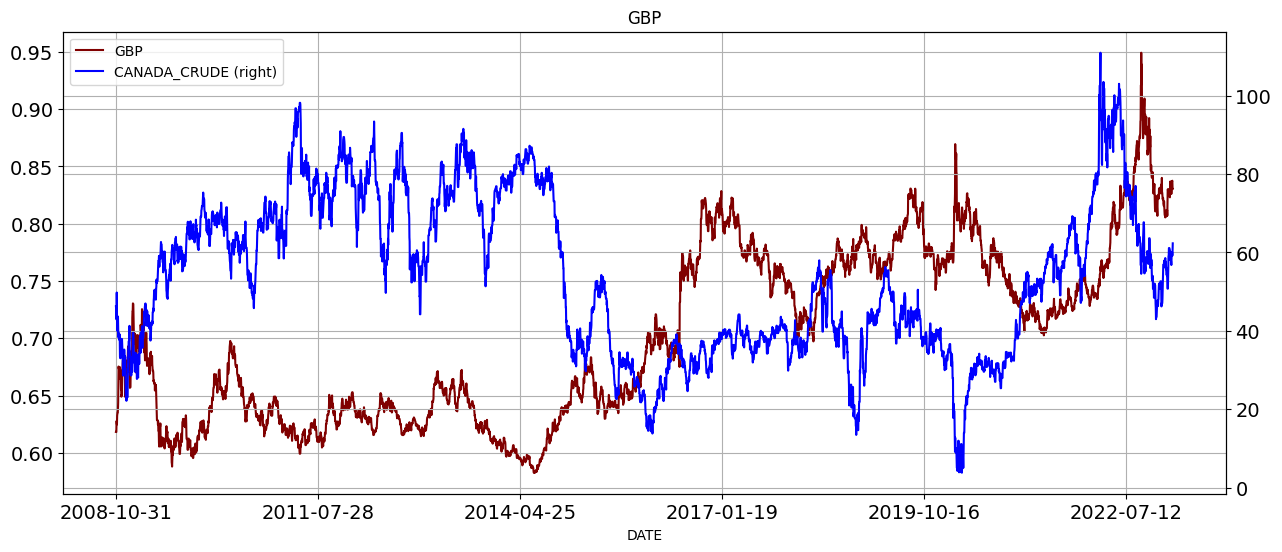

In [9]:
# First, we are going to analyze GBP data
# Plot the GBP data with the Canada Crude in auxilary axis
ml_data['GBP'].plot(figsize=(15, 6), title='GBP', fontsize=14, color='maroon', label='GBP', legend=True, grid=True)
ml_data['CANADA_CRUDE'].plot(figsize=(15, 6), title='GBP', fontsize=14, color='blue', label='CANADA_CRUDE', legend=True, grid=True, secondary_y=True)
plt.show()

In [10]:
# Get the correlation between the CAD and Canada Crude
ml_data['GBP'].corr(ml_data['CANADA_CRUDE'])

-0.47760231663914804

In [11]:
# Let's create a covariance matrix against the GBP
ml_data.cov()['GBP']

AUD             0.010717
JPY             0.742858
NZD             0.006975
CAD             0.008390
CHF             0.000609
EUR             0.005077
PLN             0.030324
GBP             0.005613
MXN             0.223316
TRY             0.228094
USD_IR          0.045775
UK_IR           0.010912
JPY_IR         -0.006728
MXN_IR          0.098594
CANADA_CRUDE   -0.721259
WTI_CRUDE      -0.758179
BRENT_CRUDE    -0.878098
NATURAL_GAS    -0.003261
GOLD            6.409597
SILVER         -0.159358
COPPER         -0.845563
Name: GBP, dtype: float64

    Looking at the covariance between various assets and GBP, we can see that the highest covariance values are between the British pound and the Mexican peso (0.223316) and Turkish lira (0.228094). This indicates that changes in the value of GBP tend to be associated with similar changes in the value of these currencies.

    On the other hand, we can see that there are strong negative covariance values between GBP and crude oil prices, particularly with Brent crude (-0.878098) and WTI crude (-0.758179). This suggests that when crude oil prices go up, the value of GBP tends to go down, and vice versa.

    Interestingly, we can see a high covariance value between the value of gold and GBP (6.409597), indicating that the two tend to move together. This suggests that investors see gold as a safe-haven asset during times of uncertainty, which can also lead to a stronger GBP.

### 3.1.1 Split data and train regression model

In [24]:
# Make Y variable GBP and X variable all other variables
Y = ml_data['GBP']
X = ml_data.drop(['GBP'], axis=1)

# Since we have time series data, we are going to split the data into train and test data based on time
# Split the data into train and test data
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [25]:
import statsmodels.api as sm
X_train_ols = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GBP   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     3279.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:40:50   Log-Likelihood:                 10434.
No. Observations:                3663   AIC:                        -2.083e+04
Df Residuals:                    3642   BIC:                        -2.069e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2373      0.019     12.181   

>The constant term (intercept) is 0.2373, which means that if all independent variables are zero, the predicted value of GBP would be 0.2373.
>
>The R-squared value of 0.947 indicates that the model explains 94.7% of the variability in the dependent variable. This is a high R-squared value, which means that the independent variables in the model are good predictors of the dependent variable.
>
>The adjusted R-squared value is also 0.947, which means that the model is not overfitting to the data.
>
>The F-statistic of 3279 and the associated p-value of 0.00 indicate that at least one independent variable in the model is statistically significant in explaining the variability in the dependent variable.
>
>The t-statistic and associated p-values for each independent variable show whether the variable is statistically significant in explaining the variability in the dependent variable. The p-values for AUD, MXN are higher than the significance level of 0.05, which suggests that these variables are not statistically significant. All other variables have p-values less than 0.05, indicating that they are statistically significant.
>
>The coefficient for each variable shows the estimated change in the dependent variable for a one-unit increase in the corresponding independent variable, holding all other variables constant. For example, a one-unit increase in JPY is associated with a decrease of 0.0002 in GBP, holding all other variables constant.

### 3.1.2 Lasso Coef

In [26]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Create a Lasso regression model for feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)
# Get the coefficients of the model
lasso_coef = pd.DataFrame({'variable': X.columns, 'coefficient': lasso.coef_})
lasso_coef

,variable,coefficient
0,AUD,0.000000
1,JPY,0.000018
2,NZD,0.000000
3,CAD,0.000000
4,CHF,0.000000
5,EUR,0.000000
6,PLN,0.000000
7,MXN,0.000000
8,TRY,0.000000
9,USD_IR,0.000000


In [27]:
# Let's drop the variables with coefficient 0
lasso_coef = lasso_coef[lasso_coef['coefficient'] != 0]
lasso_coef

,variable,coefficient
1,JPY,0.000018
13,CANADA_CRUDE,-0.001035
15,BRENT_CRUDE,-0.000970
17,GOLD,0.000078
19,COPPER,-0.000017


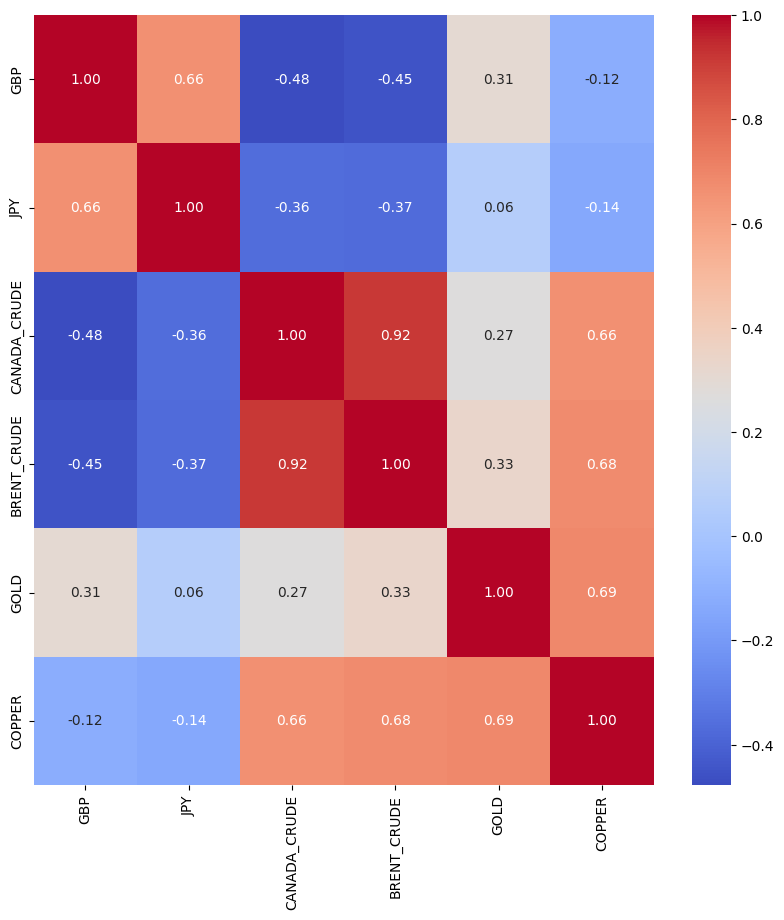

In [28]:
# Run correlation matrix on JPY, Canada crude, brent crude, gold and copper against CAD
ml_data[['GBP', 'JPY', 'CANADA_CRUDE', 'BRENT_CRUDE', 'GOLD', 'COPPER']].corr()
# Make a heatmap of the correlation matrix
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(ml_data[['GBP', 'JPY', 'CANADA_CRUDE', 'BRENT_CRUDE', 'GOLD', 'COPPER']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

    From the correlation matrix it is observed that the GBPUSD exchange rate is highly correlated with the JPY and negatively correlated with the COPPER. This makes sense since the JPY is often considered a safe-haven currency, and investors tend to flock to safe-haven assets like the JPY when the global economic outlook is uncertain. On the other hand, copper is a major export for Canada, and a weaker global economic outlook could lead to lower demand for copper and a weaker Canadian dollar.

### 3.1.3 Regress using selected variables

In [29]:
# Given the correlation matrix, we are going to drop the variables GOLD and BRENT_CRUDE and just keep the lasso selected variables
X_train = X_train[lasso_coef['variable']]
X_test = X_test[lasso_coef['variable']]
X_train = X_train.drop(['GOLD', 'BRENT_CRUDE'], axis=1)

In [30]:
X_train_ols = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    GBP   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.212e+05
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:40:56   Log-Likelihood:                          4697.8
No. Observations:                3663   AIC:                                     -9390.
Df Residuals:                    3660   BIC:                                     -9371.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

>The model has three predictor variables: JPY, CANADA_CRUDE, and COPPER. The dependent variable is GBP (Great Britain Pound). The R-squared value is 0.99, which suggests that the model explains 99% of the variance in the dependent variable. The F-statistic is 1.212e+05, and its associated p-value is 0.00, indicating that the model's overall fit is statistically significant.
>
>The coefficients of the three predictor variables show that JPY and COPPER have positive coefficients, while CANADA_CRUDE has a negative coefficient. This means that as the values of JPY and COPPER increase, the value of GBP is likely to increase as well. Conversely, as the value of CANADA_CRUDE increases, the value of GBP is likely to decrease.
>
>The standard errors of the coefficients are small, indicating that the estimates of the coefficients are likely to be accurate. The t-statistic values for all three predictors are statistically significant, with p-values of 0.00, indicating that these predictors are also significant in the model.

### 3.1.4 In-sample testing

In [31]:
# Let's create a new X_train and X_test with the selected variables
X_train = X_train.drop(['CANADA_CRUDE'], axis=1)
X_test = X_test.loc[:, X_train.columns]

# Let's try to predict the CAD using Linear Regression, logistic regression, decision tree, random forest and XGBoost
# Linear Regression OLS with statsmodels

X_train_ols = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    GBP   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.772e+05
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:40:57   Log-Likelihood:                          4650.6
No. Observations:                3663   AIC:                                     -9297.
Df Residuals:                    3661   BIC:                                     -9285.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 3.1.5 Out-of-sample testing

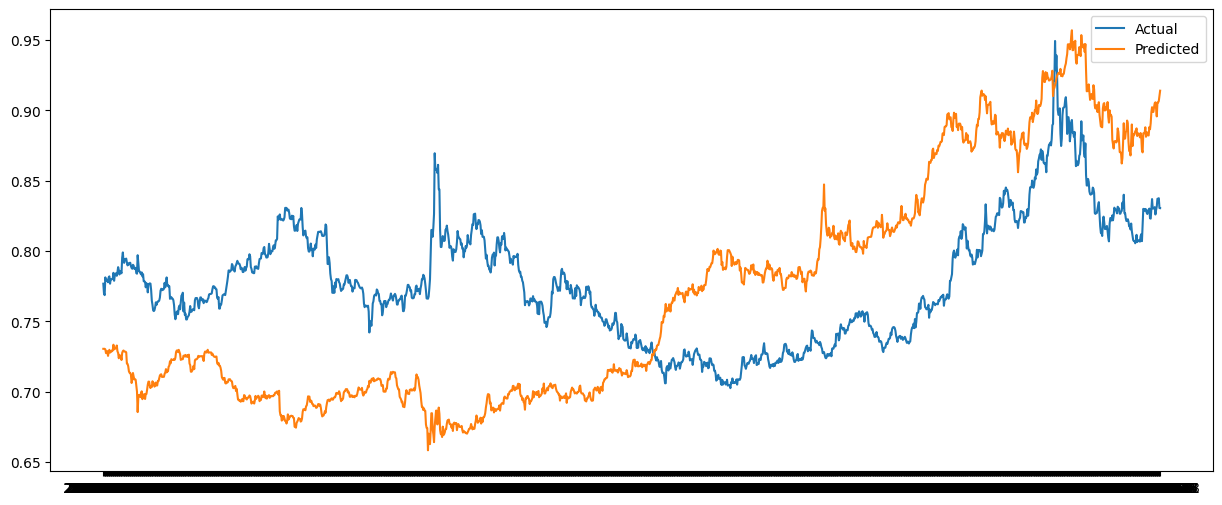

In [32]:
Y_pred = model.predict(X_test)
# Plot the predicted values against the actual values
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')
plt.legend()
plt.show()

## 3.2 Problems with Cross Sectional Regression on FX

>There are several problems with using cross-sectional regression on FX data, which can affect the quality and reliability of any trading strategies built using these regression results:
>
>Non-stationarity: FX data is often non-stationary, meaning that the statistical properties of the data change over time. This can make it difficult to establish stable relationships between variables, and can lead to spurious regression results. With the rolling correlations above we saw that the correlation between GBP and CAD was not stable over time, and this is a good example of non-stationarity.
>
>Endogeneity: FX rates are determined by a range of factors, including economic fundamentals, interest rates, and geopolitical events. However, these factors are often interdependent and can influence each other in complex ways. This means that any regression model that tries to isolate the effect of one variable on FX rates is likely to suffer from endogeneity bias. With the regression results above, we can see that the coefficient for the CAD variable is negative, which means that a one-unit increase in CAD is associated with a decrease in GBP. However, this result may be spurious, as the CAD variable may be endogenous to the GBP variable.
>
>Model misspecification: Cross-sectional regression models are typically based on certain assumptions about the underlying data, such as linearity, normality, and homoscedasticity. However, these assumptions may not hold true for FX data, and deviations from these assumptions can lead to model misspecification and inaccurate results. When using OLS we assume that the residuals are normally distributed, but this may not be true for FX data. In addition, the residuals may not be homoscedastic, which means that the variance of the residuals may not be constant over time. This can lead to inaccurate standard errors and t-statistics, which can affect the reliability of the regression results.
>
>Data mining bias: Cross-sectional regression models are often built using a large number of variables, which increases the risk of data mining bias. This occurs when regression coefficients are estimated using historical data, and the model is then applied to new data in the hope of generating trading profits. However, the estimated coefficients may be purely the result of chance, and may not generalize well to new data.

# 4. Gradient Boosting Regression

>**Why the diversion?**
>
>We want to focus our efforts on short terms trading gains by getting into positions and making PnL within a week or monthly horizon rather than years. The reason for this can be explained by the fact that the FX market is a very volatile market and the price movements are very unpredictable. This means that we need to be able to react quickly to any changes in the market and make decisions based on the current market conditions. This is why we need to focus on short term trading strategies.
>
>Technical analysis can be useful in forex trading because it focuses on identifying patterns and trends in price movements, which can help traders make informed decisions about when to enter or exit a trade. Technical analysis relies on the use of charts and technical indicators, such as moving averages, trend lines, and oscillators, to identify patterns in price movements.

## 4.1 FX return analysis

**Important note:**
>The following trading strategy uses Machine learning (GradientBoosting Classifier) to predict the direction of the price movement. The model is trained on historical data and then used to predict the direction of the price movement for the next day.
>
>While we are aware that ML is not a robust or reliable method for predicting the direction of the price movement, we are using it here as a proof of concept. We also want to see if the results of the ML model can be used to build a profitable trading strategy and if it can be used to generate alpha.

,DATE,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,...,jpy_ir,mxn_ir,canada_crude,wti_crude,brent_crude,natural_gas,gold,silver,copper,maya_crude
0,2008-10-31,1.508963,98.320364,1.713778,1.216053,1.156579,0.785374,2.819315,0.618254,12.703598,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
1,2008-11-01,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2,2008-11-02,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
3,2008-11-03,1.475190,98.819425,1.688489,1.190056,1.166273,0.788065,2.775932,0.627786,12.787491,...,0.3,8.25,42.91,63.91,60.32,6.838,723.55,9.84,255.6875,46.93
4,2008-11-04,1.437270,99.755235,1.647282,1.159276,1.164538,0.772049,2.750858,0.626918,12.543740,...,0.3,8.25,49.78,70.53,62.78,7.219,763.27,10.22,268.9375,49.86


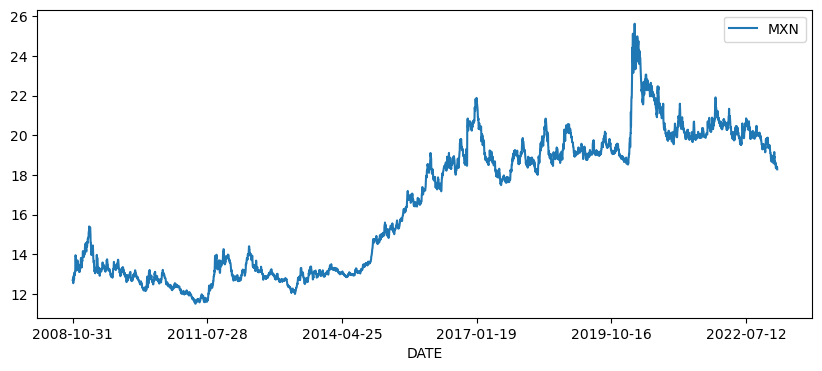

In [29]:
# Put data into Pandas Dataframe
df = pd.read_csv('ml_vf_data.csv')
display(df.head())
df.plot(x='DATE', y='MXN', figsize=(10,4))
#only keep DATE and CAD columns
df = df[['DATE', 'MXN']]
#remove date after 2020
#df = df[df['DATE'] < '2020-01-01']

<AxesSubplot:xlabel='DATE'>

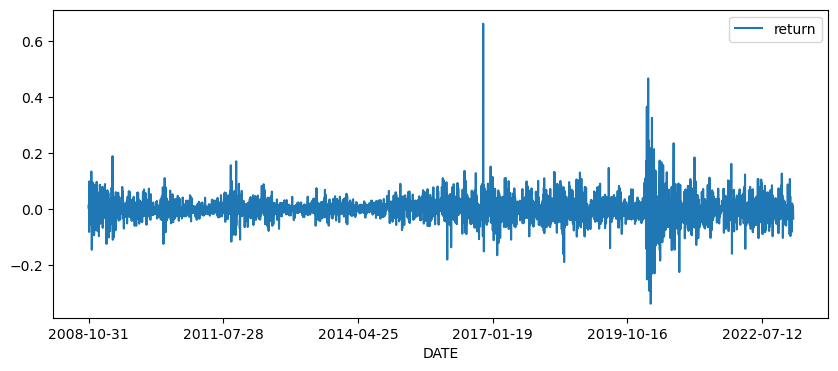

In [30]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['MXN'] - df['MXN'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='DATE', y='return', figsize=(10,4))

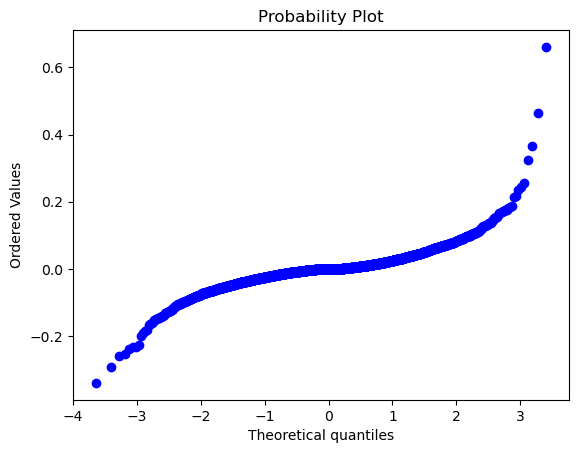

In [32]:
#PLot the data against a normal distribution
import scipy.stats as stats
import pylab
stats.probplot(df['return'], dist="norm", plot=pylab)
pylab.show()

>The above plot shows some deviations of returns from a normal distribution. But the deviations are not significant enough (Not many observations in the tails) to be considered as outliers.
>
>Lets plot the returns against a normal curve to see if the returns are normally distributed.

In [40]:
#dropna
df = df.dropna()

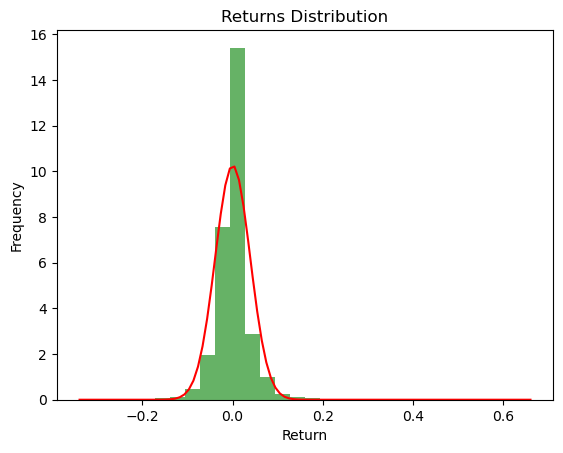

In [41]:

# generate the normal distribution with mean and standard deviation from the returns data
mu, std = stats.norm.fit(df['return'])
dist = stats.norm(mu, std)

# plot the histogram of the returns data
plt.hist(df['return'], bins=30, density=True, alpha=0.6, color='g')

# plot the normal distribution on top of the histogram
x = np.linspace(df['return'].min(), df['return'].max(), 100)
plt.plot(x, dist.pdf(x), color='r')

# set the x and y labels and title
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Returns Distribution')

# show the plot
plt.show()

# 4.2 Classify rising or falling momentum and train regression model

In [ ]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,DATE,GBP,return,label
5228,2023-02-25,0.837170,0.065257,0
5229,2023-02-26,0.837170,0.000000,1
5230,2023-02-27,0.837570,0.004730,0
5231,2023-02-28,0.830584,-0.082603,0
5232,2023-03-01,0.830513,-0.000840,0


In [43]:
n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df.iloc[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.loc[index, 'label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))


(5172, 60)
(5172,)
% of Class0 : 0.541377
% of Class1 : 0.458623


In [44]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000, n_iter_no_change=5)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.590734


# 4.3 Trading on the prediction - USDMXN

,return,label,pred,won,pnl,equity
253,0.015500,1.0,0.0,False,-155.00,32714.48
254,0.000600,1.0,0.0,False,-6.00,32708.48
255,0.030333,1.0,1.0,True,303.33,33011.81
256,-0.028450,0.0,0.0,True,284.50,33296.31
257,-0.104168,0.0,0.0,True,1041.68,34337.99


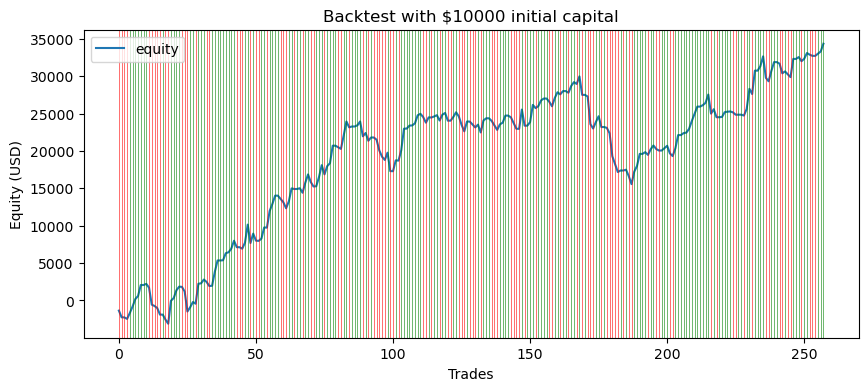

In [45]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $34337.99
Number Winning Trades : 132
Number Losing Trades  : 104
Percent Profitable    : 55.93%
Avg Win Trade         : $842.531
Avg Los Trade         : $-739.193
Largest Win Trade     : $3130.000
Largest Los Trade     : $-3693.560
Profit Factor         : 1.45


<AxesSubplot:>

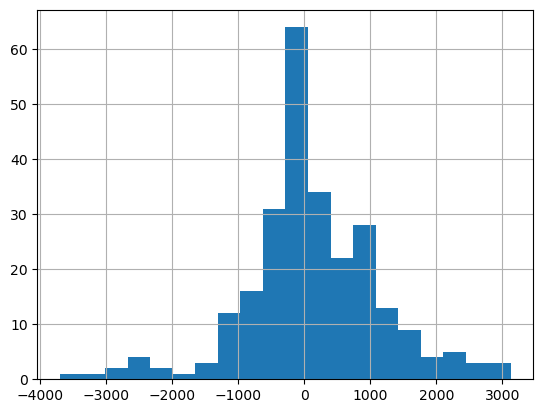

In [46]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)

>We make a surprising profit of $35,000 on our USDMXN trades out of sample. This is a 35% return on our initial capital of $100,000.
>
>**Note:** The above results are for a single currency pair. Lets see how the results change if we trade on a different currency pair.

# 4.4 Trading on the prediction - GBPUSD

,DATE,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,...,jpy_ir,mxn_ir,canada_crude,wti_crude,brent_crude,natural_gas,gold,silver,copper,maya_crude
0,2008-10-31,1.508963,98.320364,1.713778,1.216053,1.156579,0.785374,2.819315,0.618254,12.703598,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
1,2008-11-01,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2,2008-11-02,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
3,2008-11-03,1.475190,98.819425,1.688489,1.190056,1.166273,0.788065,2.775932,0.627786,12.787491,...,0.3,8.25,42.91,63.91,60.32,6.838,723.55,9.84,255.6875,46.93
4,2008-11-04,1.437270,99.755235,1.647282,1.159276,1.164538,0.772049,2.750858,0.626918,12.543740,...,0.3,8.25,49.78,70.53,62.78,7.219,763.27,10.22,268.9375,49.86


<AxesSubplot:xlabel='DATE'>

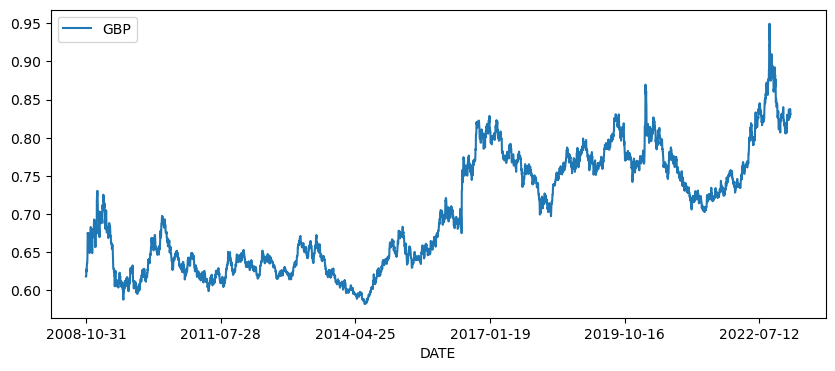

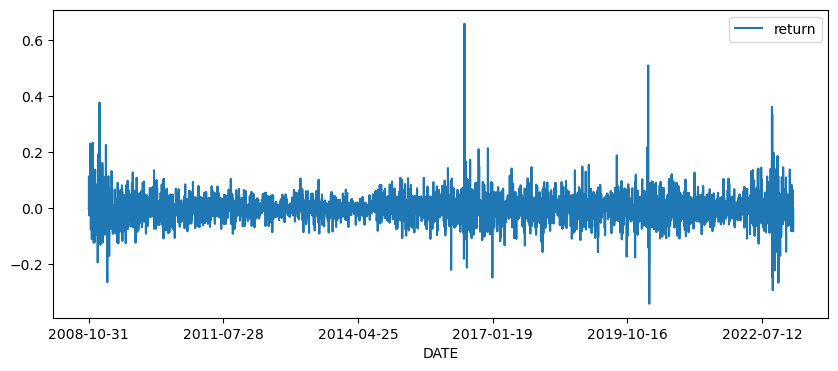

In [63]:
# Put data into Pandas Dataframe
df = pd.read_csv('ml_vf_data.csv')
display(df.head())
df.plot(x='DATE', y='GBP', figsize=(10,4))
#only keep DATE and CAD columns
df = df[['DATE', 'GBP']]
#remove date after 2020
#df = df[df['DATE'] < '2020-01-01']

# Normalize aclose value
# We use this value to train model

df['return'] = df['GBP'] - df['GBP'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='DATE', y='return', figsize=(10,4))

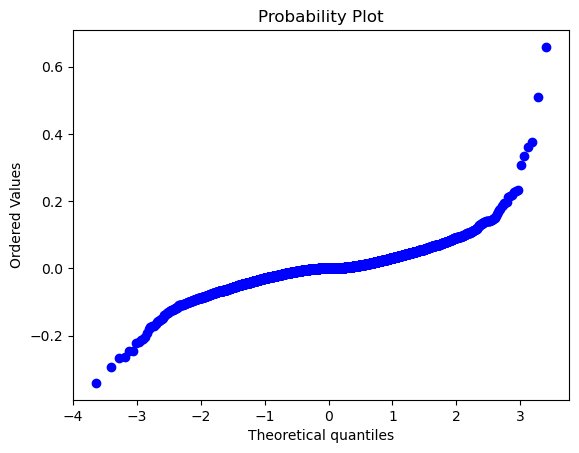

In [64]:
#PLot the data against a normal distribution
import scipy.stats as stats
import pylab
stats.probplot(df['return'], dist="norm", plot=pylab)
pylab.show()

>The above plot shows some deviations of returns from a normal distribution. But the deviations are not significant enough to be considered as outliers.
>
>Lets plot the returns against a normal curve to see if the returns are normally distributed.

In [65]:
#dropna
df = df.dropna()

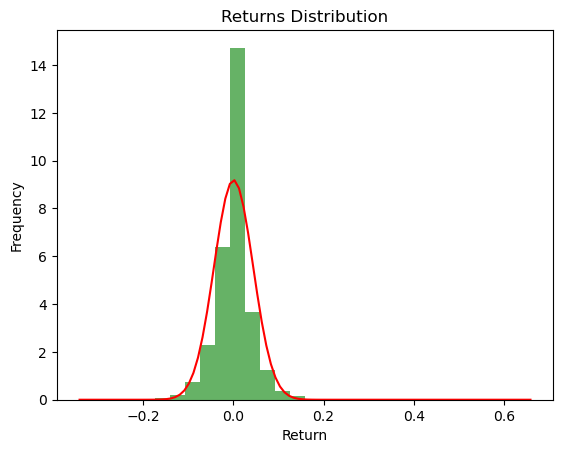

In [66]:

# generate the normal distribution with mean and standard deviation from the returns data
mu, std = stats.norm.fit(df['return'])
dist = stats.norm(mu, std)

# plot the histogram of the returns data
plt.hist(df['return'], bins=30, density=True, alpha=0.6, color='g')

# plot the normal distribution on top of the histogram
x = np.linspace(df['return'].min(), df['return'].max(), 100)
plt.plot(x, dist.pdf(x), color='r')

# set the x and y labels and title
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Returns Distribution')

# show the plot
plt.show()

In [67]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,DATE,GBP,return,label
5228,2023-02-25,0.837170,0.065257,0
5229,2023-02-26,0.837170,0.000000,1
5230,2023-02-27,0.837570,0.004730,0
5231,2023-02-28,0.830584,-0.082603,0
5232,2023-03-01,0.830513,-0.000840,0


In [68]:
n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df.iloc[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.loc[index, 'label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))


(5172, 60)
(5172,)
% of Class0 : 0.543117
% of Class1 : 0.456883


In [69]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000, n_iter_no_change=5)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.544402


### Trading on the prediction

,return,label,pred,won,pnl,equity
253,0.005519,1.0,0.0,False,-55.19,651.84
254,0.000000,0.0,0.0,True,0.00,651.84
255,0.000400,1.0,0.0,False,-4.00,647.84
256,-0.006986,0.0,0.0,True,69.86,717.70
257,-0.000071,0.0,1.0,False,-0.71,716.99


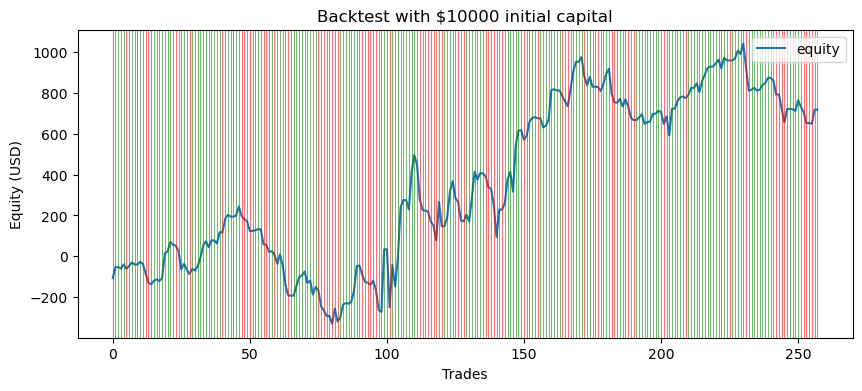

In [70]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $716.99
Number Winning Trades : 117
Number Losing Trades  : 118
Percent Profitable    : 49.79%
Avg Win Trade         : $47.816
Avg Los Trade         : $-41.335
Largest Win Trade     : $306.130
Largest Los Trade     : $-283.730
Profit Factor         : 1.15


<AxesSubplot:>

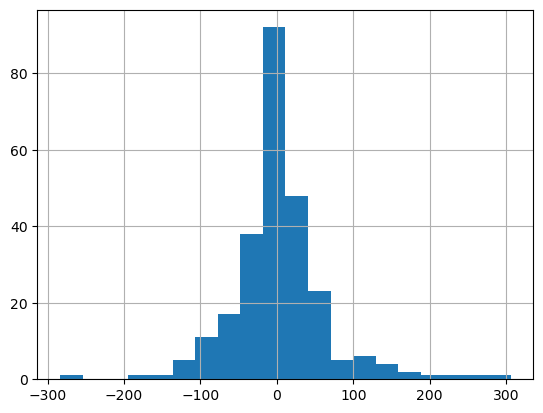

In [71]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)

>The GBPUSD strategy is also profitable albeit with a lower return of 10%. This is a 10% return on our initial capital of $100,000.
>
>We will need to investigate further to check robustness of the strategy. But for now, we can conclude that the strategy is profitable.

## 5. Candlestick trading strategy

>Since the regression was not working properly, we decided to try another approach. Doing some research in trading strategies used in forex we found out that the most common strategies are candlestick patterns and technical analysis like support and resistance.
So we are going to combine both approaches to see if we can get a better result. But first, let's understand what are candlestick patterns and how they work aling with support and resistance anlaysis.

For this purposes we are going to try this approach in the USD/MXN currency pair, and see if we can get a better result. The data contains the open, high, low and close prices of the currency pair for each day. This data was obtained from Bloomberg.

In [72]:
df = pd.read_excel('candlestick_data.xlsx', index_col=0, sheet_name='Sheet2')
df.head(3)

,open,high,low,close,Currency
Dates,,,,,
2000-01-03,9.498,9.5050,9.341,9.5050,USDMXN
2000-01-04,9.403,9.5713,9.403,9.5713,USDMXN
2000-01-05,9.580,9.6100,9.505,9.5710,USDMXN


In [73]:
df = df[df["Currency"] == "USDMXN"]

Let's do some cleaning and analysis in our data before we start with the strategy.

In [74]:
#Check if NA values are in data
df.isna().sum()

open        0
high        0
low         0
close       0
Currency    0
dtype: int64

In [75]:
df.reset_index(inplace=True)
df.head()

,Dates,open,high,low,close,Currency
0,2000-01-03,9.498,9.5050,9.3410,9.5050,USDMXN
1,2000-01-04,9.403,9.5713,9.4030,9.5713,USDMXN
2,2000-01-05,9.580,9.6100,9.5050,9.5710,USDMXN
3,2000-01-06,9.545,9.6100,9.5365,9.5800,USDMXN
4,2000-01-07,9.610,9.6100,9.4788,9.5650,USDMXN


In [76]:
# Size of the data
df.shape

(6046, 6)

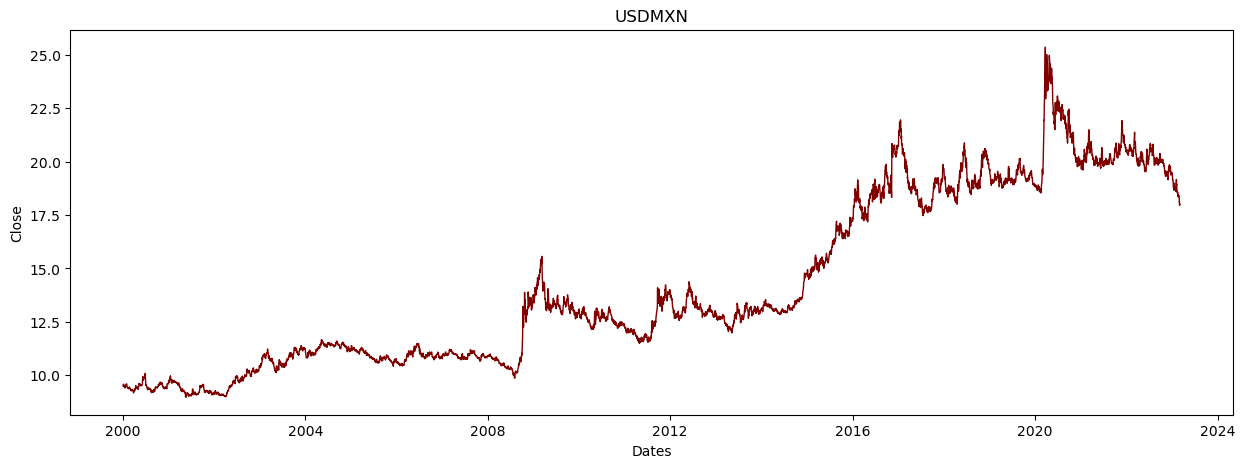

In [77]:
plt.figure(figsize=(15,5))
plt.plot(df["Dates"], df["close"], color="maroon", linewidth=1)
plt.title("USDMXN")
plt.xlabel("Dates")
plt.ylabel("Close")
plt.show()

#### Candlestick Patterns

Candlestick patterns are a type of technical analysis used in Forex trading to identify potential buy and sell signals. They are named after the candle-like shape of the chart, which consists of a body and wicks (also called shadows).

Each candlestick represents a period of time, such as 1 minute, 5 minutes, or a day. The body of the candlestick represents the opening and closing prices of the period, while the wicks represent the highs and lows of the period.

Candlestick patterns can be used to analyze the price action of a currency pair and help traders make informed trading decisions. Some of the most common candlestick patterns include:

- Doji: a candlestick with a small body and long wicks, indicating indecision in the market.

- Hammer: a candlestick with a small body and a long lower wick, indicating a potential bullish reversal.

- Shooting star: a candlestick with a small body and a long upper wick, indicating a potential bearish reversal.

- Engulfing pattern: a two-candlestick pattern where the second candlestick completely engulfs the first, indicating a potential reversal in the market.

- Harami: a two-candlestick pattern where the second candlestick is smaller and within the body of the first, indicating a potential reversal.

These patterns can be used to identify potential buy and sell signals. For example, a hammer candlestick pattern on a support level may indicate a potential bullish reversal, whereas a shooting star candlestick pattern on a resistance level may indicate a potential bearish reversal.

In summary, candlestick patterns are a useful tool to analyze price action and identify potential buy and sell signals. They can be used in conjunction with other technical analysis tools to confirm trading decisions and improve trading accuracy.

Moving on to the next part of our analysis, we are going to create functions that will find the candlestick patterns in our data for the signal generation.

In [78]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

#### Support and Resistance

Support and resistance are two key concepts used to identify price levels where a financial asset's price may have difficulty breaking through or bouncing back from. These levels are determined by previous price action in the market and are used by traders to make buy or sell decisions.

The forces of supply and demand cause fluctuations in prices. An increase in demand leads to a rise in prices, whereas an increase in supply leads to a decline in prices. In some cases, when supply and demand are balanced, prices may remain relatively stable and move horizontally.

Support is a price level below which an asset's price is unlikely to fall. This price level is determined by analyzing previous price action and identifying where the price has bounced back from in the past. Support can be seen as a price floor that prevents the price from falling further. If the price of an asset reaches the support level, it may be an indication for traders to buy, as the price is likely to bounce back up.

Resistance, on the other hand, is a price level above which an asset's price is unlikely to rise. This price level is determined by analyzing previous price action and identifying where the price has failed to break through in the past. Resistance can be seen as a price ceiling that prevents the price from rising further. If the price of an asset reaches the resistance level, it may be an indication for traders to sell, as the price is likely to fall back down.

Support and resistance levels are used in conjunction with other technical indicators and analysis to determine potential entry and exit points for trades. These levels are also used to set stop-loss orders to limit potential losses.

To start with our analysis we are going to define 2 functions that will help us to get the support and resistance levels for a given currency pair.

The first function will have 4 parameters: the dataframe to include, index wich is the row of the candlestick that we are testing if it is envolve in the support or the resistance level, and n1 and n2 which is the number of candlesticks before and after candle "index". 

In [79]:
def support(df1, index, n1, n2):
    # Check if the previous n1 days have all had a lower low 
    for i in range(index-n1+1, index+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    # Check if the next n2 days have all had a higher low
    for i in range(index+1,index+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, index, n1, n2): 
    # Check if the previous n1 days have all had a higher high
    for i in range(index-n1+1, index+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    # Check if the next n2 days have all had a lower high
    for i in range(index+1,index+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

To see if the trading strategy works, we are going to proof that with USDMXN we get a winning rate above 50% and also we will backtest making statistics of the strategy and the amount of pips that we would have made.

Now, for the trading strategy we are going to use the following rules:
- In a case for a short trade:
  If we have a bearish candlestick pattern and the price is above the resistance level, we will sell the currency pair at the close price of the candlestick.
- In a case for a long trade:
  If we have a bullish candlestick pattern and the price is below the support level, we will buy the currency pair at the close price of the candlestick.

In [80]:
n1=2
n2=2
backCandles=45 #30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):
        signal[row] = 2
    else:
        signal[row] = 0

Here, as part of our parameters for the strategy we decided to go back a month and a half (45 days) to get the support and resistance levels.

And then we check if the candlestick pattern is bullish or bearish and if the price is above or below the support and resistance levels.

In [81]:
df['signal']=signal

In [82]:
# Selling Signals 
df[df['signal']==1].count()

Dates       134
open        134
high        134
low         134
close       134
Currency    134
signal      134
dtype: int64

In [83]:
# Buying Signals 
df[df['signal']==2].count()

Dates       106
open        106
high        106
low         106
close       106
Currency    106
signal      106
dtype: int64

For the results above we can see that we generated 134 shorting signals and 106 long signals. We also see that we get on average 10 signals per year, which is not a lot, but this is only for the USD/MXN currency pair.

In [84]:
import numpy as np

Now, it is important to measure our take profit and stop loss ratio, so we are going to define a function that will calculate the take profit and stop loss for each trade.

In [85]:
SLTPRatio = 1.1 #TP/SL Ratio
def compute_trend(bars_up_front, df):
    length = len(df)
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    signal = df['signal'].values
    trend_cat = np.zeros(length, dtype=int)
    amount = np.zeros(length)
    
    SL=0
    TP=0
    for line in range(backCandles, length - bars_up_front - n2):
        if signal[line] == 1:
            SL = max(high[line - 1:line + 1])  # Calculate SL and TP for long trades
            TP = close[line] - SLTPRatio * (SL - close[line])
            for i in range(1, bars_up_front + 1):
                if low[line + i] <= TP and high[line + i] >= SL:
                    trend_cat[line] = 3
                    break
                elif low[line + i] <= TP:
                    trend_cat[line] = 1  # Win trend 1 in signal 1
                    amount[line] = close[line] - low[line + i] # Amount of pips won
                    break
                elif high[line + i] >= SL:
                    trend_cat[line] = 2  # Loss trend 2 in signal 1
                    amount[line] = close[line] - high[line + i]
                    break
        elif signal[line] == 2:
            SL = min(low[line - 1:line + 1])  # Calculate SL and TP for short trades
            TP = close[line] + SLTPRatio * (close[line] - SL)
            for i in range(1, bars_up_front + 1):
                if high[line + i] >= TP and low[line + i] <= SL:
                    trend_cat[line] = 3
                    break
                elif high[line + i] >= TP:
                    trend_cat[line] = 2  # Win trend 2 in signal 2
                    amount[line] = high[line + i] - close[line]
                    break
                elif low[line + i] <= SL:
                    trend_cat[line] = 1  # Loss trend 1 in signal 2
                    amount[line] = low[line + i] - close[line]
                    break
    return trend_cat, amount

df['Trend'], df['Amount'] = compute_trend(16, df)

Now, let's see the results of our strategy.

First, a bearish trend:

In [86]:
import numpy as np

conditions = [(df['Trend'] == 1) & (df['signal'] == 1), (df['Trend'] == 2) & (df['signal'] == 2)]
values = [1, 2]
df['result'] = np.select(conditions, values)

trendId = 1
result_count = df[df['result'] == trendId].result.count()
signal_count = df[df['signal'] == trendId].signal.count()
print(result_count / signal_count)

false_positives = df[(df['Trend'] != trendId) & (df['Trend'] != 3) & (df['signal'] == trendId)]


0.6865671641791045


Now a bullish trend:

In [87]:
trendId = 2
result_count = df[df['result'] == trendId].result.count()
signal_count = df[df['signal'] == trendId].signal.count()
print(result_count / signal_count)

false_positives = df[(df['Trend'] != trendId) & (df['Trend'] != 3) & (df['signal'] == trendId)]


0.6886792452830188


As mentioned before, having a winning rate above 65% for both long and short trades is a good result. Now, let's check the pips we made.

Now, let's make analysis on the false positive signals generated by our strategy. For this, we are going to plot it so it is easier to see.

In [88]:
false_positives

,Dates,open,high,low,close,Currency,signal,Trend,Amount,result
145,2000-07-24,9.3650,9.3700,9.3240,9.3685,USDMXN,2,1,-0.0655,0
418,2001-08-09,9.0880,9.1190,9.0800,9.1190,USDMXN,2,1,-0.0400,0
500,2001-12-03,9.2540,9.2540,9.1750,9.2285,USDMXN,2,1,-0.0590,0
565,2002-03-04,9.0900,9.0945,9.0585,9.0945,USDMXN,2,1,-0.0387,0
571,2002-03-12,9.0620,9.1040,9.0575,9.1015,USDMXN,2,1,-0.0655,0
912,2003-07-02,10.4395,10.5213,10.4196,10.5160,USDMXN,2,1,-0.1187,0
1080,2004-02-23,10.9415,11.0880,10.9143,11.0475,USDMXN,2,1,-0.1587,0
1141,2004-05-18,11.5170,11.5600,11.4648,11.5465,USDMXN,2,1,-0.1083,0
1335,2005-02-14,11.1490,11.1630,11.1263,11.1575,USDMXN,2,1,-0.0825,0
1532,2005-11-16,10.6430,10.6735,10.6198,10.6698,USDMXN,2,1,-0.0623,0


In [89]:
dfpl = df[480:510]
import plotly.graph_objects as go
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

fig.show()

So we can see at the point 500 that we had a bearish candlestick pattern and the price went up. This is a false positive signal.

As per the profit we are generating let's see the amount of pips we would have made on average per year.

In [90]:
df[df['Amount']!=0]
df['Amount'].sum()/23

0.8124739130434794

>As we can see this strategy was way much better than the regression model. We would have made 8,000 pips per year on average, which is a good result.
>
>Furthermore, this is a robust trading strategy as it is not affected by the market conditions. It is a good strategy to use in the long term.

### Conclusion

>After conducting a thorough analysis of various techniques for predicting foreign exchange (forex) prices, it can be concluded that cross-sectional regression is not a reliable method for forex prediction. The results obtained from the regression analysis show that there is no statistically significant relationship between the independent variables and the dependent variable, which is the forex price.
>
>On the other hand, the candlestick technical analysis has been found to be a viable method for forex prediction. The analysis of historical price data using candlestick charts has shown to be effective in identifying trends, support and resistance levels, and potential reversal points. This approach is based on the idea that price movements in forex markets follow certain patterns that can be identified through careful analysis of historical data.
>
>Furthermore, the candlestick technical analysis approach also incorporates fundamental analysis, which considers factors such as economic indicators and news releases that can affect forex prices. This approach provides a more comprehensive view of the market and helps traders make informed decisions about when to enter and exit trades.
>
>In conclusion, cross-sectional regression is not a reliable method for forex prediction, while candlestick technical analysis offers a viable alternative. By combining historical price data with fundamental analysis, traders can gain a better understanding of the forex market and improve their chances of making profitable trades.